# MLP
MLP, K=5, epochs=200.
Use lncRNA.
Train set: filter none.
Valid set: filter tails.

In [1]:
from datetime import datetime
print(datetime.now())

2023-04-04 12:27:14.322155


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = True
FILTER_TAILS_TEST   = True
FILTER_MIDDLE_TEST  = False

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-04 12:27:51.582532
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                65664     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if not FILTER_TEST or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if not FILTER_TRAIN or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-04 12:27:52.710695
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-04-04 12:28:14.294472

Training # 1 1
2023-04-04 12:28:14.296117
2023-04-04 12:28:14.296184
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 178:150 54.27%
FIT
2023-04-04 12:28:14.374969


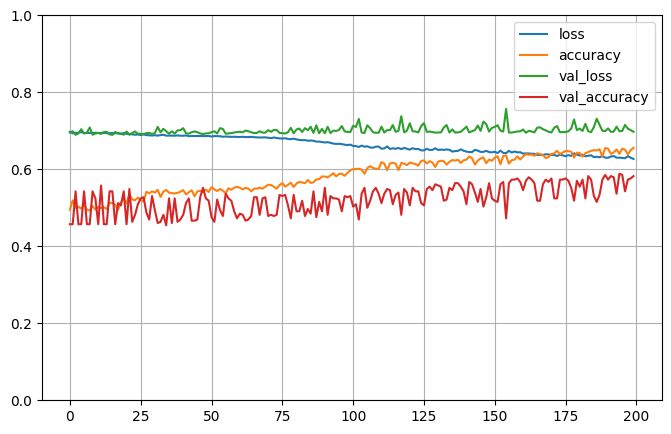


2023-04-04 12:30:37.910891

Testing # 1 1
2023-04-04 12:30:37.911333
2023-04-04 12:30:37.911385
PREDICT
2023-04-04 12:30:37.913729
Test 1:0 178:150 54.27%
Predict 1:0 231:97 70.43%
Test sizes (328, 1025) (328,)
Range of scores: 0.048213705 to 0.93193424
Score threshold 0.5
Confusion matrix
 [[ 55  95]
 [ 42 136]]
Normalized matrix
 [[0.16768293 0.28963415]
 [0.12804878 0.41463415]]


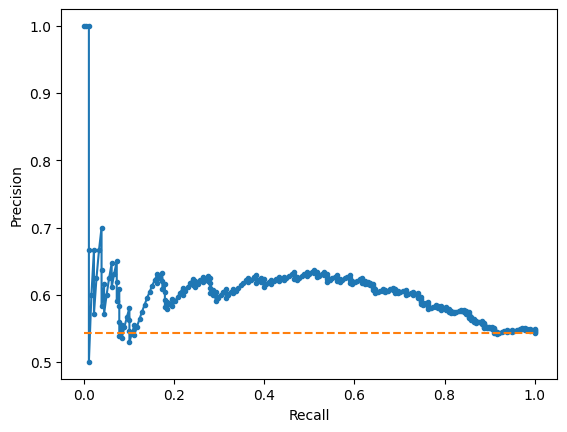

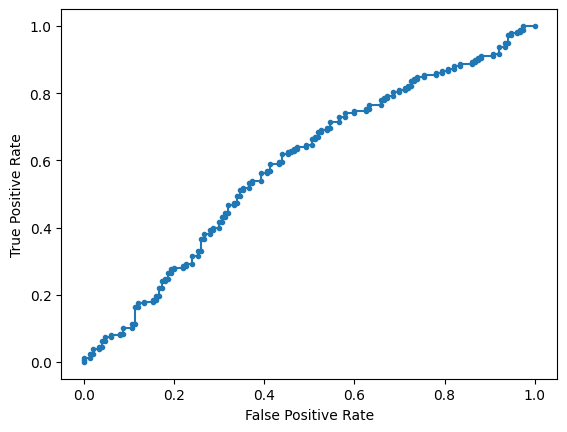

Accuracy: 58.23% Precision: 58.87% Recall: 76.40%
F1: 66.50% MCC: 0.1427
AUPRC: 60.27% AUROC: 58.66%
 accuracy [58.231707317073166]
 precision [58.87445887445888]
 recall [76.40449438202246]
 F1 [66.50366748166259]
 MCC [0.14268487502815402]
 AUPRC [60.274395280058854]
 AUROC [58.659176029962545]
2023-04-04 12:30:39.235102

Training # 1 2
2023-04-04 12:30:39.235348
2023-04-04 12:30:39.235408
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 193:179 51.88%
FIT
2023-04-04 12:30:39.323238


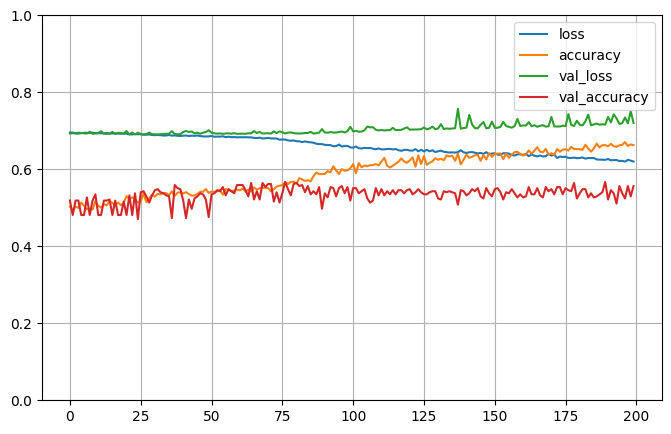


2023-04-04 12:33:02.698472

Testing # 1 2
2023-04-04 12:33:02.704506
2023-04-04 12:33:02.704946
PREDICT
2023-04-04 12:33:02.709233
Test 1:0 193:179 51.88%
Predict 1:0 254:118 68.28%
Test sizes (372, 1025) (372,)
Range of scores: 0.027350325 to 0.9392799
Score threshold 0.5
Confusion matrix
 [[ 66 113]
 [ 52 141]]
Normalized matrix
 [[0.17741935 0.30376344]
 [0.13978495 0.37903226]]


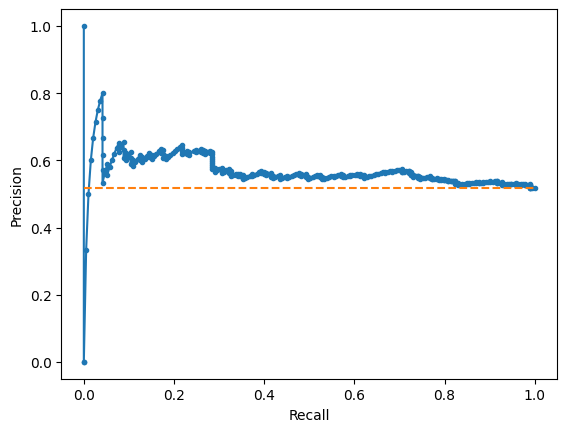

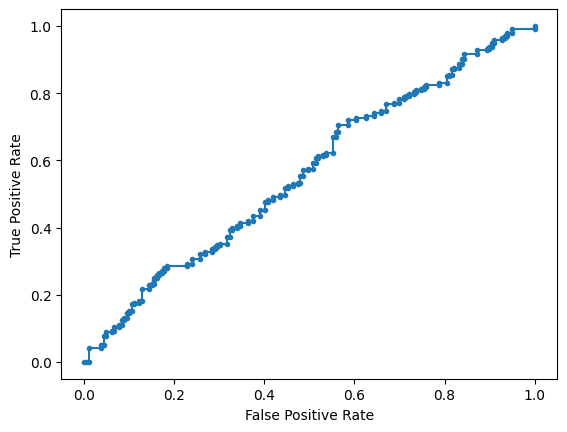

Accuracy: 55.65% Precision: 55.51% Recall: 73.06%
F1: 63.09% MCC: 0.1066
AUPRC: 56.73% AUROC: 56.12%
 accuracy [55.64516129032258]
 precision [55.51181102362205]
 recall [73.05699481865285]
 F1 [63.08724832214766]
 MCC [0.10659358972664086]
 AUPRC [56.73273097689867]
 AUROC [56.117752626856166]
2023-04-04 12:33:04.286337

Training # 1 3
2023-04-04 12:33:04.287689
2023-04-04 12:33:04.287759
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 185:148 55.56%
FIT
2023-04-04 12:33:04.648551


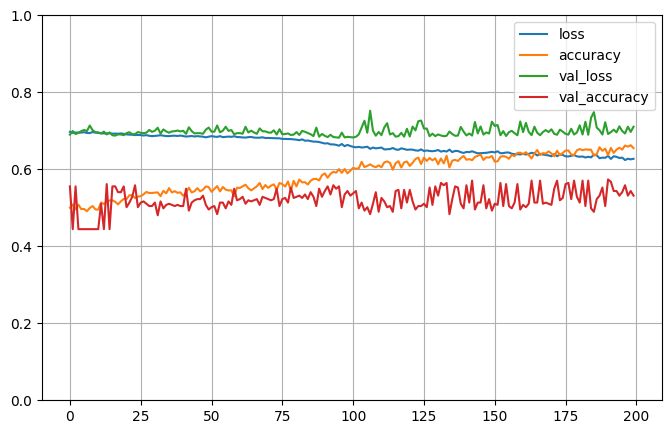


2023-04-04 12:34:28.595584

Testing # 1 3
2023-04-04 12:34:28.595702
2023-04-04 12:34:28.595748
PREDICT
2023-04-04 12:34:28.599102
Test 1:0 185:148 55.56%
Predict 1:0 113:220 33.93%
Test sizes (333, 1025) (333,)
Range of scores: 0.05667243 to 0.9378205
Score threshold 0.5
Confusion matrix
 [[106  42]
 [114  71]]
Normalized matrix
 [[0.31831832 0.12612613]
 [0.34234234 0.21321321]]


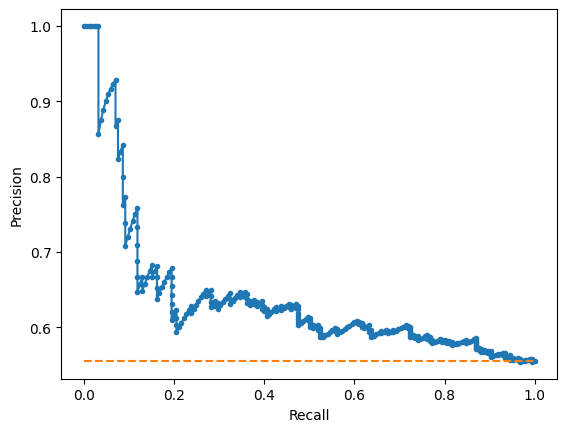

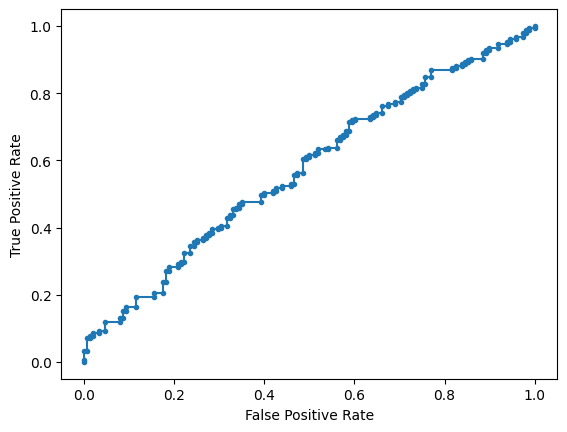

Accuracy: 53.15% Precision: 62.83% Recall: 38.38%
F1: 47.65% MCC: 0.1049
AUPRC: 63.81% AUROC: 57.35%
 accuracy [53.153153153153156]
 precision [62.83185840707964]
 recall [38.37837837837838]
 F1 [47.6510067114094]
 MCC [0.10494606514251895]
 AUPRC [63.812392428805396]
 AUROC [57.34842951059168]
2023-04-04 12:34:29.855259

Training # 1 4
2023-04-04 12:34:29.856715
2023-04-04 12:34:29.857350
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 191:179 51.62%
FIT
2023-04-04 12:34:29.938208


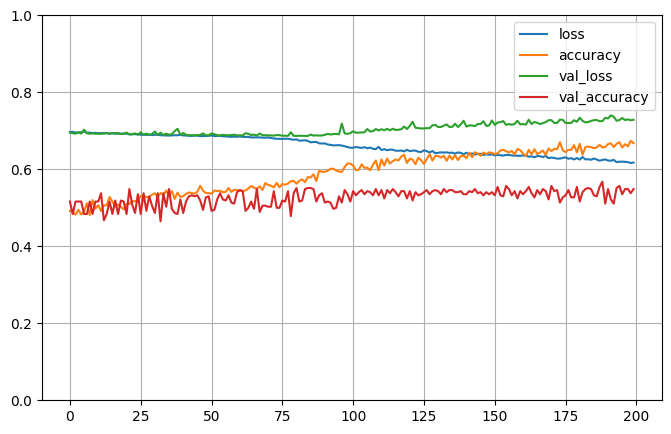


2023-04-04 12:36:53.157091

Testing # 1 4
2023-04-04 12:36:53.157214
2023-04-04 12:36:53.157287
PREDICT
2023-04-04 12:36:53.164279
Test 1:0 191:179 51.62%
Predict 1:0 234:136 63.24%
Test sizes (370, 1025) (370,)
Range of scores: 0.042506363 to 0.956802
Score threshold 0.5
Confusion matrix
 [[ 74 105]
 [ 62 129]]
Normalized matrix
 [[0.2        0.28378378]
 [0.16756757 0.34864865]]


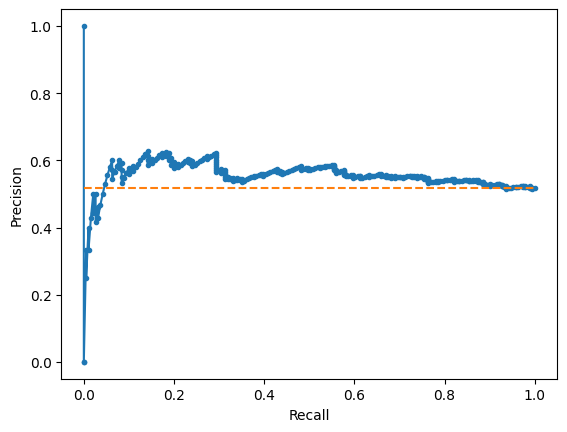

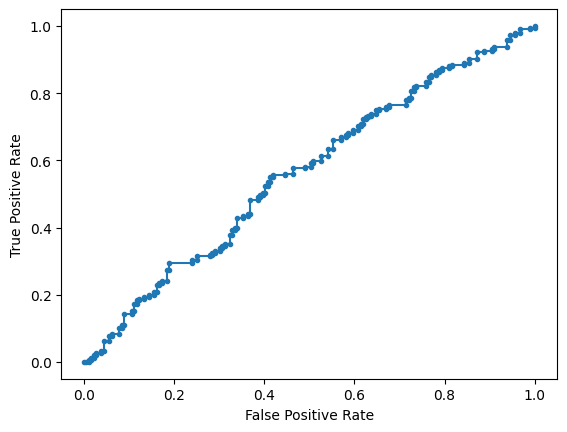

Accuracy: 54.86% Precision: 55.13% Recall: 67.54%
F1: 60.71% MCC: 0.0920
AUPRC: 55.38% AUROC: 56.19%
 accuracy [54.864864864864856]
 precision [55.12820512820513]
 recall [67.5392670157068]
 F1 [60.705882352941174]
 MCC [0.092040969631774]
 AUPRC [55.38259425370724]
 AUROC [56.19351253327094]
2023-04-04 12:36:55.409334

Training # 1 5
2023-04-04 12:36:55.411661
2023-04-04 12:36:55.412068
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 188:162 53.71%
FIT
2023-04-04 12:36:55.545218


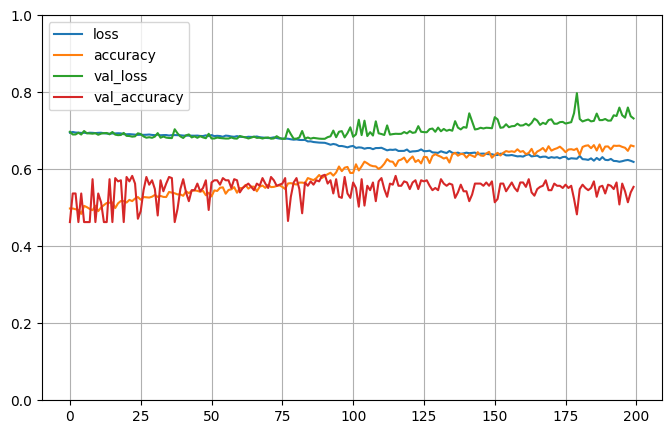


2023-04-04 12:39:19.179802

Testing # 1 5
2023-04-04 12:39:19.179916
2023-04-04 12:39:19.179961
PREDICT
2023-04-04 12:39:19.183577
Test 1:0 188:162 53.71%
Predict 1:0 228:122 65.14%
Test sizes (350, 1025) (350,)
Range of scores: 0.01637755 to 0.9636832
Score threshold 0.5
Confusion matrix
 [[ 64  98]
 [ 58 130]]
Normalized matrix
 [[0.18285714 0.28      ]
 [0.16571429 0.37142857]]


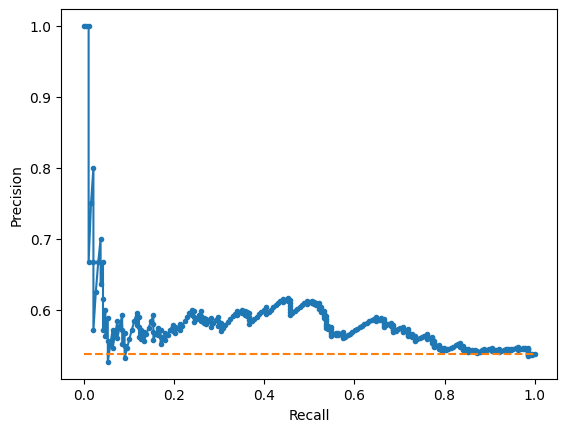

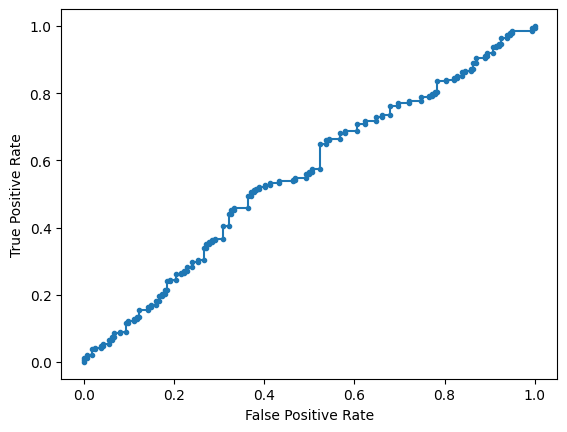

Accuracy: 55.43% Precision: 57.02% Recall: 69.15%
F1: 62.50% MCC: 0.0906
AUPRC: 58.02% AUROC: 55.45%
 accuracy [55.42857142857143]
 precision [57.01754385964912]
 recall [69.14893617021278]
 F1 [62.5]
 MCC [0.09056525935902726]
 AUPRC [58.01871865450625]
 AUROC [55.44720252167061]
2023-04-04 12:39:21.271492

Training # 2 1
2023-04-04 12:39:21.272732
2023-04-04 12:39:21.272798
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 198:157 55.77%
FIT
2023-04-04 12:39:21.358121


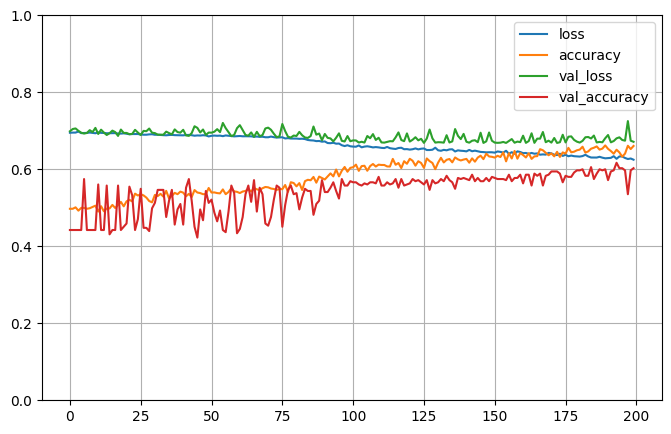


2023-04-04 12:40:50.062400

Testing # 2 1
2023-04-04 12:40:50.062548
2023-04-04 12:40:50.062596
PREDICT
2023-04-04 12:40:50.070345
Test 1:0 198:157 55.77%
Predict 1:0 225:130 63.38%
Test sizes (355, 1025) (355,)
Range of scores: 0.050530273 to 0.95009375
Score threshold 0.5
Confusion matrix
 [[ 73  84]
 [ 57 141]]
Normalized matrix
 [[0.2056338  0.23661972]
 [0.16056338 0.3971831 ]]


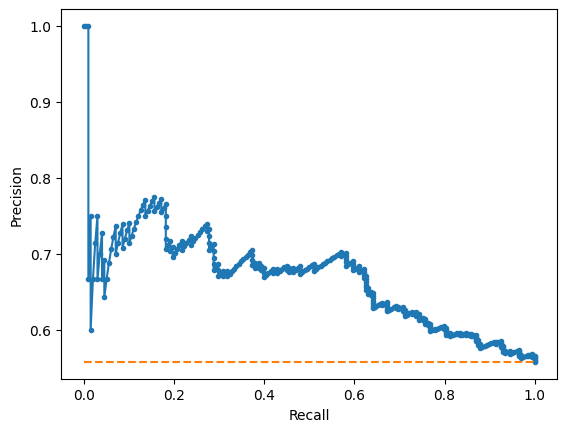

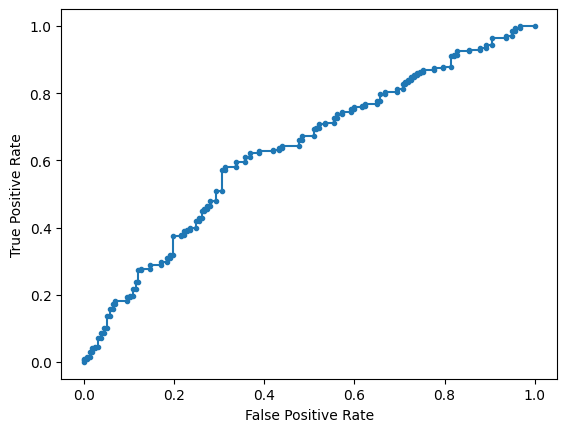

Accuracy: 60.28% Precision: 62.67% Recall: 71.21%
F1: 66.67% MCC: 0.1826
AUPRC: 66.66% AUROC: 63.07%
 accuracy [60.281690140845065]
 precision [62.66666666666667]
 recall [71.21212121212122]
 F1 [66.66666666666667]
 MCC [0.1825626649707671]
 AUPRC [66.6640792211243]
 AUROC [63.06697548735766]
2023-04-04 12:40:51.332836

Training # 2 2
2023-04-04 12:40:51.333814
2023-04-04 12:40:51.333880
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 191:153 55.52%
FIT
2023-04-04 12:40:51.421321


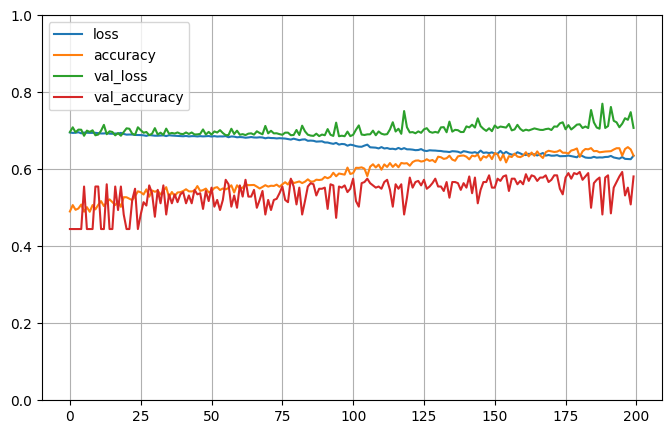


2023-04-04 12:42:17.977290

Testing # 2 2
2023-04-04 12:42:17.977416
2023-04-04 12:42:17.977462
PREDICT
2023-04-04 12:42:17.986062
Test 1:0 191:153 55.52%
Predict 1:0 235:109 68.31%
Test sizes (344, 1025) (344,)
Range of scores: 0.054367356 to 0.96456707
Score threshold 0.5
Confusion matrix
 [[ 59  94]
 [ 50 141]]
Normalized matrix
 [[0.17151163 0.27325581]
 [0.14534884 0.40988372]]


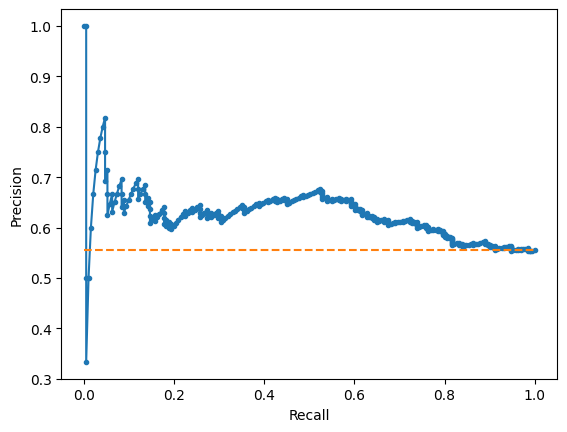

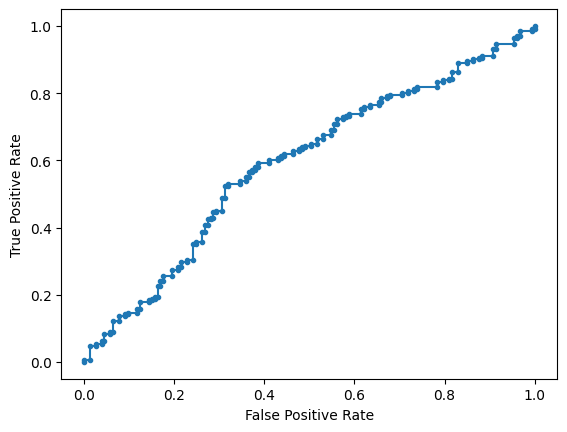

Accuracy: 58.14% Precision: 60.00% Recall: 73.82%
F1: 66.20% MCC: 0.1323
AUPRC: 62.49% AUROC: 59.13%
 accuracy [58.139534883720934]
 precision [60.0]
 recall [73.82198952879581]
 F1 [66.19718309859155]
 MCC [0.1322753757739014]
 AUPRC [62.49111208209936]
 AUROC [59.13492796769668]
2023-04-04 12:42:19.279375

Training # 2 3
2023-04-04 12:42:19.279623
2023-04-04 12:42:19.279685
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 177:165 51.75%
FIT
2023-04-04 12:42:19.362791


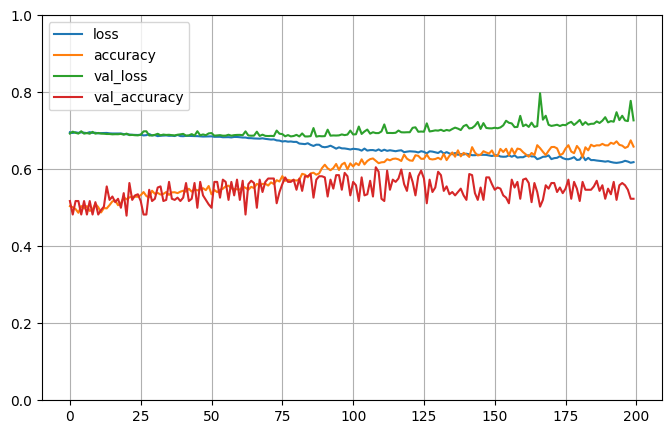


2023-04-04 12:43:43.936384

Testing # 2 3
2023-04-04 12:43:43.936507
2023-04-04 12:43:43.936564
PREDICT
2023-04-04 12:43:43.945480
Test 1:0 177:165 51.75%
Predict 1:0 190:152 55.56%
Test sizes (342, 1025) (342,)
Range of scores: 0.00659899 to 0.94569755
Score threshold 0.5
Confusion matrix
 [[ 77  88]
 [ 75 102]]
Normalized matrix
 [[0.2251462  0.25730994]
 [0.21929825 0.29824561]]


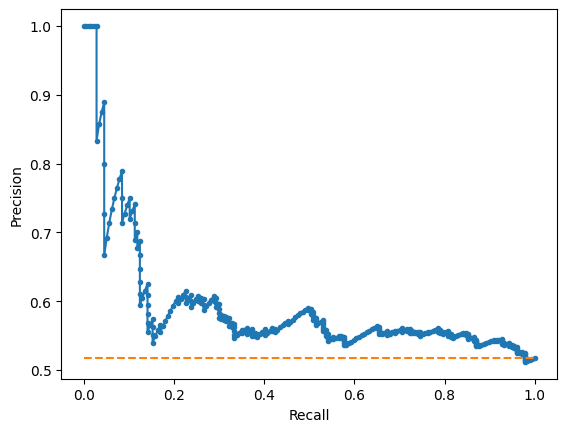

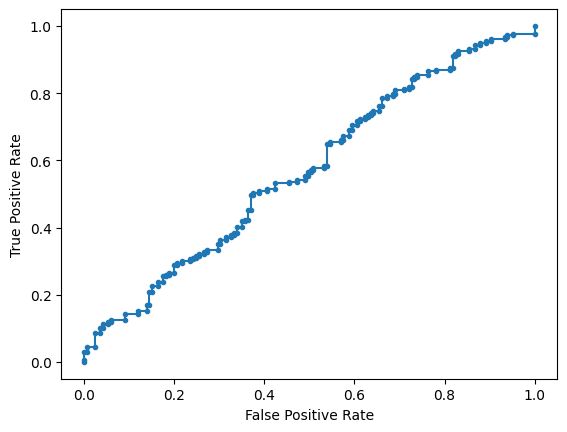

Accuracy: 52.34% Precision: 53.68% Recall: 57.63%
F1: 55.59% MCC: 0.0432
AUPRC: 59.14% AUROC: 56.97%
 accuracy [52.33918128654971]
 precision [53.68421052631579]
 recall [57.6271186440678]
 F1 [55.5858310626703]
 MCC [0.043178776958837276]
 AUPRC [59.14494528257281]
 AUROC [56.973121040917654]
2023-04-04 12:43:45.829708

Training # 2 4
2023-04-04 12:43:45.830757
2023-04-04 12:43:45.830835
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 177:178 49.86%
FIT
2023-04-04 12:43:45.913863


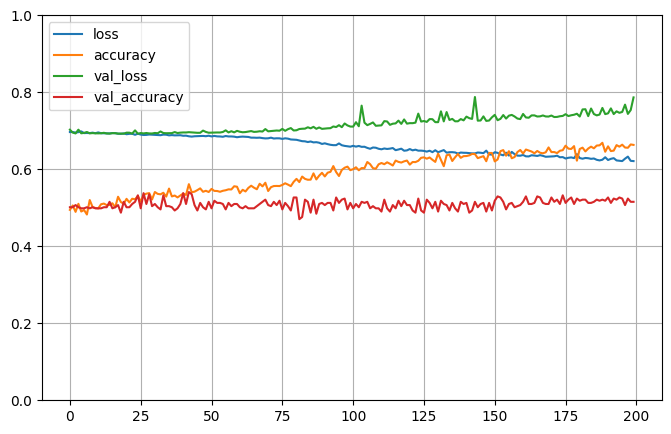


2023-04-04 12:46:09.183090

Testing # 2 4
2023-04-04 12:46:09.183203
2023-04-04 12:46:09.183246
PREDICT
2023-04-04 12:46:09.191245
Test 1:0 177:178 49.86%
Predict 1:0 43:312 12.11%
Test sizes (355, 1025) (355,)
Range of scores: 0.013632436 to 0.8738702
Score threshold 0.5
Confusion matrix
 [[159  19]
 [153  24]]
Normalized matrix
 [[0.44788732 0.05352113]
 [0.43098592 0.06760563]]


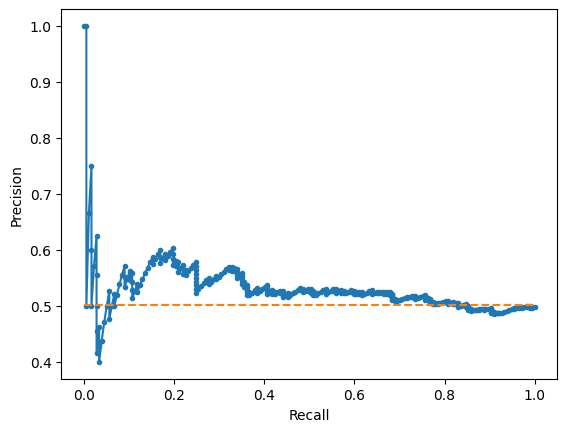

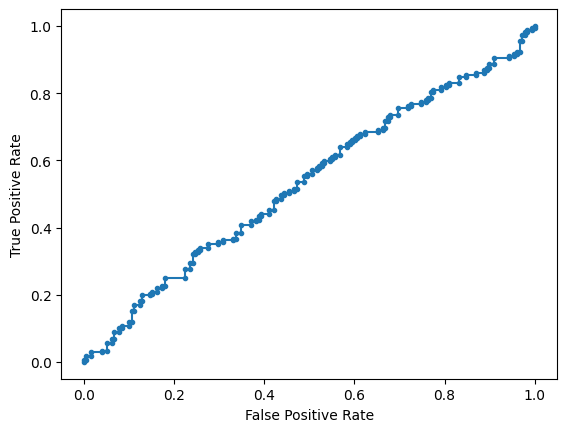

Accuracy: 51.55% Precision: 55.81% Recall: 13.56%
F1: 21.82% MCC: 0.0442
AUPRC: 52.98% AUROC: 53.25%
 accuracy [51.54929577464789]
 precision [55.81395348837209]
 recall [13.559322033898304]
 F1 [21.818181818181817]
 MCC [0.044213584344469356]
 AUPRC [52.9811432625753]
 AUROC [53.247000571319745]
2023-04-04 12:46:10.474726

Training # 2 5
2023-04-04 12:46:10.474974
2023-04-04 12:46:10.475034
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 192:165 53.78%
FIT
2023-04-04 12:46:10.555523


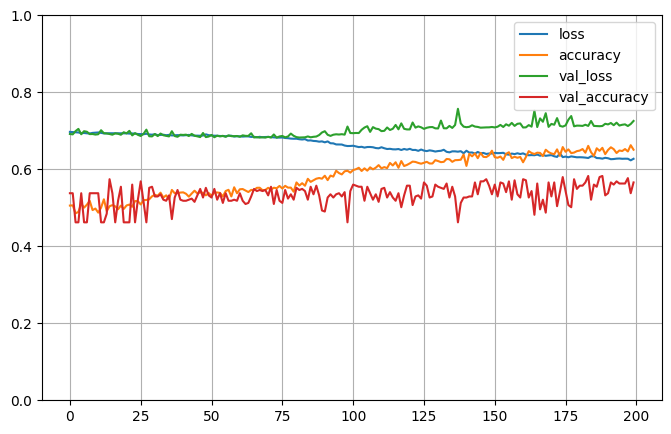


2023-04-04 12:48:33.756225

Testing # 2 5
2023-04-04 12:48:33.756337
2023-04-04 12:48:33.756384
PREDICT
2023-04-04 12:48:33.766392
Test 1:0 192:165 53.78%
Predict 1:0 293:64 82.07%
Test sizes (357, 1025) (357,)
Range of scores: 0.04538861 to 0.9592592
Score threshold 0.5
Confusion matrix
 [[ 37 128]
 [ 27 165]]
Normalized matrix
 [[0.10364146 0.35854342]
 [0.07563025 0.46218487]]


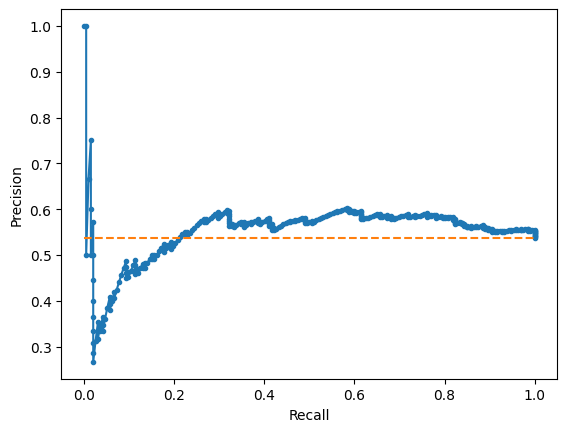

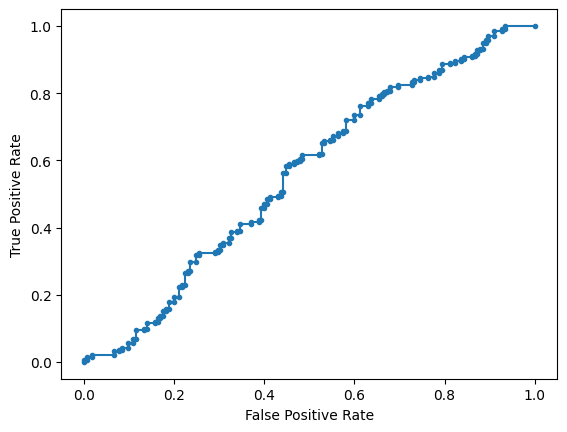

Accuracy: 56.58% Precision: 56.31% Recall: 85.94%
F1: 68.04% MCC: 0.1087
AUPRC: 55.40% AUROC: 55.69%
 accuracy [56.582633053221286]
 precision [56.31399317406144]
 recall [85.9375]
 F1 [68.04123711340205]
 MCC [0.10868399020983749]
 AUPRC [55.39584239355834]
 AUROC [55.69444444444444]
2023-04-04 12:48:34.335713


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 55.62% std 2.79
 precision mean 57.78% std 3.18
 recall mean 62.67% std 21.42
 F1 mean 57.88% std 14.11
 MCC mean 0.10% std 0.04
 AUPRC mean 59.09% std 4.27
 AUROC mean 57.19% std 2.66
 accuracy [[58.231707317073166], [55.64516129032258], [53.153153153153156], [54.864864864864856], [55.42857142857143], [60.281690140845065], [58.139534883720934], [52.33918128654971], [51.54929577464789], [56.582633053221286]]
 precision [[58.87445887445888], [55.51181102362205], [62.83185840707964], [55.12820512820513], [57.01754385964912], [62.66666666666667], [60.0], [53.68421052631579], [55.81395348837209], [56.31399317406144]]
 recall [[76.40449438202246], [73.05699481865285], [38.37837837837838], [67.5392670157068], [69.14893617021278], [71.21212121212122], [73.82198952879581], [57.6271186440678], [13.559322033898304], [85.9375]]
 F1 [[66.50366748166259], [63.08724832214766], [47.6510067114094], [60.705882352941174], [62.5], [66.66666666666667], [66.19718309859155], [55.5858310626703